# **Machine Learning Notebook**

This notebook trains and evaluates a Gradient Boosting Decision Tree (GBDT) model using XGBoost on the processed financial data:

- Train XGBoost GBDT model on the engineered features.
- Perform hyperparameter optimization using Optuna to find the best model configuration.
- Evaluate model performance by comparing predictions against actual target values.
- Visualize model effectiveness through evaluation metrics.

---

## **Import required libraries**

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import optuna
from optuna.samplers import TPESampler
from optuna.trial import Trial

from xgboost import XGBRegressor

from huggingface_hub import hf_hub_download

## **Set random seed for reproducibility**

In [2]:
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

## **Get the train and test datasets**

> **Download them or create the data from the `2.feature-engineering.ipynb` file.**

In [3]:
files_to_download = [
    "processed/train_dataset.parquet",
    "processed/test_dataset.parquet"
]

for file_path in files_to_download:
    hf_hub_download(
        repo_id="Sierra-Arn/finml-lab-data",
        filename=file_path,
        repo_type="dataset",
        local_dir="../data"
    )

In [4]:
TRAIN_DATASET = pd.read_parquet("../data/processed/train_dataset.parquet")
TEST_DATASET = pd.read_parquet("../data/processed/test_dataset.parquet")
TRAIN_DATASET

,volume,SAREXT,BBANDS_168_lower,ADXR_24,ADXR_72,ADXR_168,DX_24,STOCHRSI_D,APO,TRIX_24,...,ADOSC,HT_DCPERIOD,HT_PHASOR_inphase,candles_since_start,day_sin,day_cos,dayofweek_sin,dayofyear_sin,dayofyear_cos,target
datetime,,,,,,,,,,,,,,,,,,,,,
2019-09-29 15:00:00,-0.658306,-0.346546,-0.462336,-0.124939,3.512950,0.899938,0.523148,-0.879569,-0.232243,-0.190074,...,-0.141437,-0.598128,-0.091463,-1.000000,-0.394356,0.918958,-0.781831,-0.999445,-0.033324,8030.37
2019-09-29 16:00:00,-0.660630,-0.345946,-0.462387,-0.137929,3.527011,0.908001,0.218589,-0.313678,-0.256722,-0.216076,...,-0.033029,-0.501344,-0.148179,-0.999934,-0.394356,0.918958,-0.781831,-0.999445,-0.033324,7992.37
2019-09-29 17:00:00,-0.746731,-0.345393,-0.462457,-0.153903,3.533877,0.916463,0.218589,0.070743,-0.294233,-0.242533,...,-0.020802,-0.332337,-0.338037,-0.999868,-0.394356,0.918958,-0.781831,-0.999445,-0.033324,7979.04
2019-09-29 18:00:00,-0.753508,-0.344885,-0.462528,-0.158915,3.541345,0.925067,0.336171,0.388530,-0.314814,-0.269679,...,-0.032233,-0.104525,-0.479410,-0.999802,-0.394356,0.918958,-0.781831,-0.999445,-0.033324,7956.40
2019-09-29 19:00:00,-0.681509,-0.344418,-0.462589,-0.163113,3.548563,0.933450,0.466980,0.007797,-0.331318,-0.298315,...,-0.059596,0.174145,-0.406518,-0.999736,-0.394356,0.918958,-0.781831,-0.999445,-0.033324,7988.76
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-16 22:00:00,0.346819,0.405311,-0.059926,-0.252510,1.587580,0.848089,-0.053801,-0.044386,0.973026,0.276827,...,0.590154,0.289365,-0.558910,0.999670,-0.101168,-0.994869,0.433884,0.960885,0.276946,24990.40
2023-03-16 23:00:00,0.503839,0.406352,-0.059041,-0.279120,1.590006,0.859231,0.030071,0.472106,0.935950,0.291036,...,0.657140,0.313627,-0.537790,0.999736,-0.101168,-0.994869,0.433884,0.960885,0.276946,24904.60
2023-03-17 00:00:00,0.344056,0.407330,-0.057941,-0.305768,1.593602,0.871140,-0.028413,0.461721,0.908673,0.304720,...,0.303549,0.366213,0.419432,0.999802,-0.299363,-0.954139,-0.433884,0.965507,0.260376,25654.40


## **Optuna hyperparameter optimization**

In [5]:
def objective(trial: Trial):
    """
    Objective function for Optuna hyperparameter optimization.
    
    This function defines the search space for XGBoost hyperparameters and evaluates
    model performance using cross-validation. It's used by Optuna to find the optimal
    hyperparameter combination that minimizes RMSE on the validation set.
    
    Args:
        trial (optuna.trial.Trial): Optuna trial object for hyperparameter sampling
        
    Returns:
        float: Validation RMSE score (minimization target for Optuna)
    """

    params = {
        "n_estimators": 100,
        "max_depth": trial.suggest_int("max_depth", 2, 20),
        "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.3, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-3, 10.0, log=True),  # L2
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-3, 10.0, log=True),    # L1
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "random_state": SEED,
        "tree_method": "hist",
        "device": "cuda",
        "eval_metric": "rmse",
        "early_stopping_rounds": 20
    }

    X_data = TRAIN_DATASET.drop(columns=["target"])
    y_data = TRAIN_DATASET["target"]
    X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.2, random_state=SEED, shuffle=False)

    model = XGBRegressor(**params)
    model.fit(
        X_train,
        y_train,
        eval_set=[(X_val, y_val)],
        verbose=False
    )

    preds = model.predict(X_val)
    val_mse = mean_squared_error(y_val, preds)
    val_rmse = np.sqrt(val_mse)

    return val_rmse

In [6]:
# TPESampler uses Tree-structured Parzen Estimator algorithm for efficient search
# It learns from previous trials to suggest better hyperparameter combinations
sampler = TPESampler(seed=SEED)

# Create study to minimize the objective function (validation RMSE)
study = optuna.create_study(direction="minimize", sampler=sampler)

[I 2025-08-12 11:07:35,721] A new study created in memory with name: no-name-71a24d24-e4e3-461a-9740-423bc54bac47


In [10]:
study.optimize(objective, n_trials=10)

[I 2025-08-12 11:12:02,367] Trial 30 finished with value: 4280.42088748394 and parameters: {'max_depth': 6, 'learning_rate': 0.10728200580567805, 'reg_lambda': 0.3860394691697273, 'reg_alpha': 0.012437934365517243, 'subsample': 0.5450433630589988, 'colsample_bytree': 0.8354592880933636}. Best is trial 16 with value: 2157.447534615298.
[I 2025-08-12 11:12:02,658] Trial 31 finished with value: 2436.7454257874165 and parameters: {'max_depth': 3, 'learning_rate': 0.19331899414361245, 'reg_lambda': 0.20132424188149872, 'reg_alpha': 0.6409266917506126, 'subsample': 0.5408460035578481, 'colsample_bytree': 0.9833091895978893}. Best is trial 16 with value: 2157.447534615298.
[I 2025-08-12 11:12:02,790] Trial 32 finished with value: 2190.6189384246754 and parameters: {'max_depth': 2, 'learning_rate': 0.17972034125152966, 'reg_lambda': 0.12829176679078827, 'reg_alpha': 0.18489880796966737, 'subsample': 0.5360879888217329, 'colsample_bytree': 0.9583590280474262}. Best is trial 16 with value: 2157.

## **View the best hyperparameters**

In [11]:
best_trial = study.best_trial
best_trial

FrozenTrial(number=33, state=1, values=[2067.2139278312457], datetime_start=datetime.datetime(2025, 8, 12, 11, 12, 2, 791068), datetime_complete=datetime.datetime(2025, 8, 12, 11, 12, 2, 945202), params={'max_depth': 2, 'learning_rate': 0.18642899876111482, 'reg_lambda': 0.20928319533789203, 'reg_alpha': 0.1708233554411829, 'subsample': 0.5383069463555508, 'colsample_bytree': 0.9679710449086409}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'max_depth': IntDistribution(high=20, log=False, low=2, step=1), 'learning_rate': FloatDistribution(high=0.3, log=True, low=0.005, step=None), 'reg_lambda': FloatDistribution(high=10.0, log=True, low=0.001, step=None), 'reg_alpha': FloatDistribution(high=10.0, log=True, low=0.001, step=None), 'subsample': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 'colsample_bytree': FloatDistribution(high=1.0, log=False, low=0.5, step=None)}, trial_id=33, value=None)

In [12]:
best_params = best_trial.params
best_params

{'max_depth': 2,
 'learning_rate': 0.18642899876111482,
 'reg_lambda': 0.20928319533789203,
 'reg_alpha': 0.1708233554411829,
 'subsample': 0.5383069463555508,
 'colsample_bytree': 0.9679710449086409}

## **Train the GBDT model on the best hyperparameters**

In [13]:
X_data = TRAIN_DATASET.drop(columns=["target"])
y_data = TRAIN_DATASET["target"]

X_test_data = TEST_DATASET.drop(columns=["target"])
y_test_data = TEST_DATASET["target"]

model = XGBRegressor(**best_params)
model.fit(X_data, y_data, verbose=False)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.9679710449086409
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


## **Evaluate the GBDT model**

In [14]:
preds = model.predict(X_test_data)
val_mse = mean_squared_error(y_test_data, preds)
val_rmse = np.sqrt(val_mse)
val_rmse

np.float64(1523.3198674894668)

## **Visualize model effectiveness through evaluation metrics**

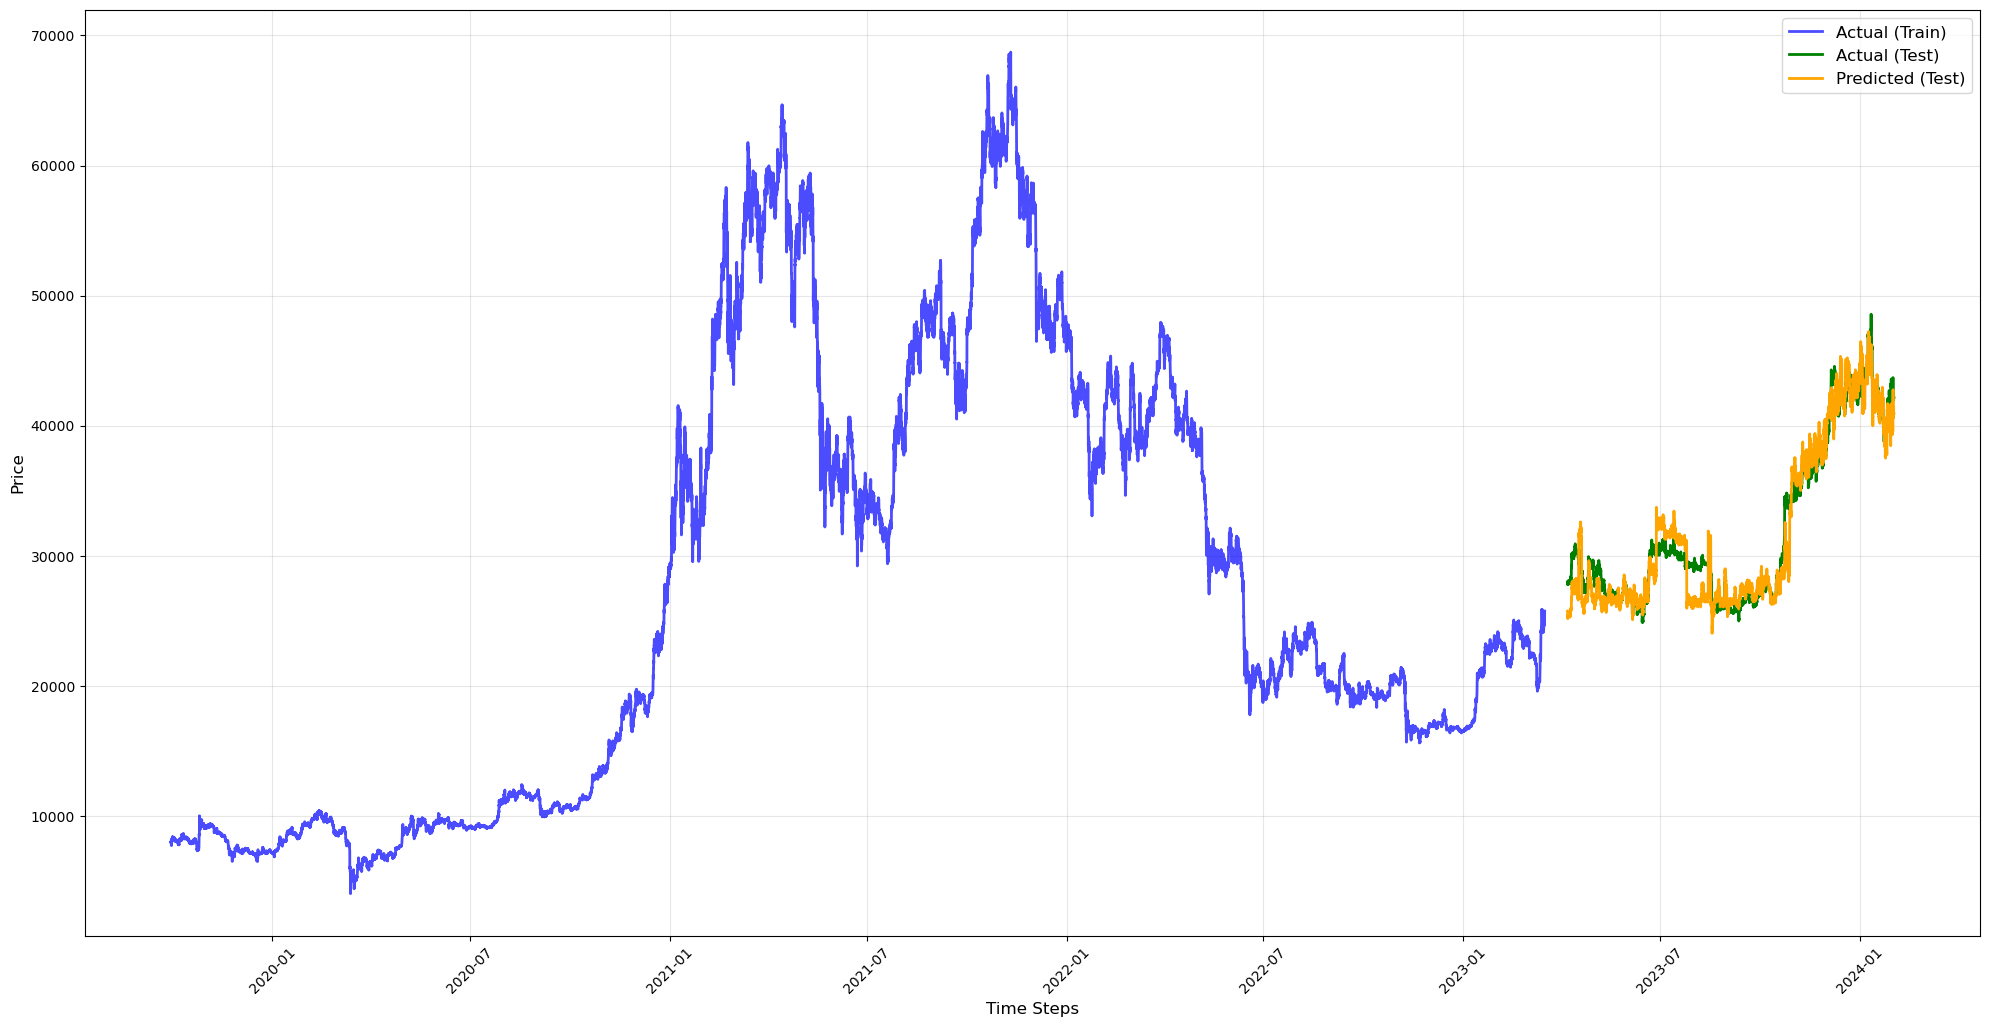

In [15]:
plt.figure(figsize=(20, 10))

train_timestamps = y_data.index
test_timestamps = y_test_data.index

plt.plot(train_timestamps, y_data.values, label='Actual (Train)', linewidth=2, color='blue', alpha=0.7)
plt.plot(test_timestamps, y_test_data.values, label='Actual (Test)', linewidth=2, color='green')
plt.plot(test_timestamps, preds, label='Predicted (Test)', linewidth=2, color='orange')

plt.xlabel('Time Steps', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

## **Save the model for reusing**

In [16]:
model.save_model("../models/financial_gbdt_regressor.json")